In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Introduction**:
Everyday we come across various products in our lives, on the digital medium we swipe across hundreds of product choices under one category. It will be tedious for the customer to make selection. Here comes 'reviews' where customers who have already got that product leave a rating after using them and brief their experience by giving reviews. As we know ratings can be easily sorted and judged whether a product is good or bad. But when it comes to sentence reviews we need to read through every line to make sure the review conveys a positive or negative sense. In the era of artificial intelligence, things like that have got easy with the Natural Langauge Processing(NLP) technology.

Sentiment Analysis is the most common text classification tool that analyses an incoming message and tells whether the underlying sentiment is positive, negative our neutral.Understanding people’s emotions is essential for businesses since customers are able to express their thoughts and feelings more openly than ever before.It is quite hard for a human to go through each single line and identify the emotion being the user experience.Now with technology, we can automatically analyzing customer feedback, from survey responses to social media conversations, brands are able to listen attentively to their customers, and tailor products and services to meet their needs.

**Importing Libraries:**


In [2]:
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

**Importing the dataset:** 

In [3]:
raw_reviews=pd.read_json('/content/drive/MyDrive/Data/Musical_Instruments_5.json',lines=True)
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10261 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB
None


In [4]:
raw_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


 **Dataset Details:**
 
This file has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time

Description of columns in the file:

1.  reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2.  asin - ID of the product, e.g. 0000013714
3.  reviewerName - name of the reviewer
4.  helpful - helpfulness rating of the review, e.g. 2/3
5.  reviewText - text of the review
6.  overall - rating of the product
7.  summary - summary of the review
8.  unixReviewTime - time of the review (unix time)
9.  reviewTime - time of the review (raw)

**Preprocessing and cleaning:**

**Handling NaN values:**

Let's check for null values

In [5]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

We got null values in reviewer names and review text. Reviewer names doesn't add any value(we got id's instead) to our objective of the project. So let's focus on review text. I don't think dropping wouldn't be a problem as there are only 7 null values, but instead I'm thinking to impute that as missing and explore why they didn't leave any review . Could it be due to ratings?

In [6]:
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

**Concatenating review text and summary:**

Let's combine review text and summary column. The sentiments won't be contradicting in nature.

In [7]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"02 28, 2014","Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,"03 16, 2013",The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5,1377648000,"08 28, 2013",The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...


**Creating 'sentiment' column:**

This is an important preprocessing phase, we are deciding the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, we take that as positive and if the value is less than 3 it is negative If it is equal to 3, we take that as neutral sentiment

In [8]:
#Figuring out the distribution of categories
process_reviews['overall'].value_counts()

5    6938
4    2084
3     772
2     250
1     217
Name: overall, dtype: int64

In [9]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [10]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()


,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"02 28, 2014","Not much to write about here, but it does exac...",Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,"03 16, 2013",The product does exactly as it should and is q...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5,1377648000,"08 28, 2013",The primary job of this device is to block the...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and preven...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,"02 21, 2014",This pop filter is great. It looks and perform...,Positive


In [11]:
process_reviews['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

**Handling time column:**

Here we have an unusual review time column which has date and year, once we split both we will split the date further into month and date.

In [12]:
# new data frame which has date and year
new = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
process_reviews["date"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["year"]= new[1] 

process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()


,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviews,sentiment,date,year
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"Not much to write about here, but it does exac...",Positive,02 28,2014
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,The product does exactly as it should and is q...,Positive,03 16,2013
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5,1377648000,The primary job of this device is to block the...,Positive,08 28,2013
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,02 14,2014
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,This pop filter is great. It looks and perform...,Positive,02 21,2014


In [13]:
process_reviews['helpful'][0]

[0, 0]

In [14]:
# Splitting the date 
new1 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["month"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["day"]= new1[1] 

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviews,sentiment,year,month,day
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5,1393545600,"Not much to write about here, but it does exac...",Positive,2014,02,28
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5,1363392000,The product does exactly as it should and is q...,Positive,2013,03,16
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5,1377648000,The primary job of this device is to block the...,Positive,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,2014,02,14
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5,1392940800,This pop filter is great. It looks and perform...,Positive,2014,02,21


In [15]:
for i in range(0,len(process_reviews["helpful"])):
  process_reviews["helpful"][i] = [str(x) for x in process_reviews["helpful"][i]]
  process_reviews["helpful"][i]  = ' '.join([str(elem) for elem in process_reviews["helpful"][i]])

In [16]:
process_reviews

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviews,sentiment,year,month,day
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...",0 0,5,1393545600,"Not much to write about here, but it does exac...",Positive,2014,02,28
1,A14VAT5EAX3D9S,1384719342,Jake,13 14,5,1363392000,The product does exactly as it should and is q...,Positive,2013,03,16
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""",1 1,5,1377648000,The primary job of this device is to block the...,Positive,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""",0 0,5,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,2014,02,14
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,0 0,5,1392940800,This pop filter is great. It looks and perform...,Positive,2014,02,21
...,...,...,...,...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,0 0,5,1405814400,"Great, just as expected. Thank to all.Five Stars",Positive,2014,07,20
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,0 0,5,1404259200,I've been thinking about trying the Nanoweb st...,Positive,2014,07,2
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,0 0,4,1405987200,I have tried coated strings in the past ( incl...,Positive,2014,07,22
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""",0 0,4,1404172800,"Well, MADE by Elixir and DEVELOPED with Taylor...",Positive,2014,07,1


In [17]:
process_reviews.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviews,sentiment,year,month,day
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...",0 0,5,1393545600,"Not much to write about here, but it does exac...",Positive,2014,02,28
1,A14VAT5EAX3D9S,1384719342,Jake,13 14,5,1363392000,The product does exactly as it should and is q...,Positive,2013,03,16
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""",1 1,5,1377648000,The primary job of this device is to block the...,Positive,2013,08,28
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""",0 0,5,1392336000,Nice windscreen protects my MXL mic and preven...,Positive,2014,02,14
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,0 0,5,1392940800,This pop filter is great. It looks and perform...,Positive,2014,02,21


In [18]:
# Splitting the dataset based on comma and square bracket 
new1 =pd.DataFrame(process_reviews["helpful"].str.split(" ", n = 1,expand=True))

# I found few spaces in new1, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

#Applying the function
helpful= trim_all_columns(new1)

#Converting into integer types
helpful[0]=new1[0].astype(str).astype(int)
helpful[1]=new1[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0
helpful['result'] =helpful['result'].replace(np.inf, 0)
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=helpful['result']

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)



In [19]:
process_reviews['helpful_rate'].value_counts()

0.00    7215
1.00    2040
2.00     266
1.50     136
1.33     111
        ... 
1.54       1
2.18       1
1.44       1
8.50       1
1.80       1
Name: helpful_rate, Length: 79, dtype: int64

**Review text-Punctuation Cleaning:**

Let's begin our text processing by removing the punctuations

In [20]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [21]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [22]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

,reviewerID,asin,overall,reviews,sentiment,year,month,day,helpful_rate
0,A2IBPI20UZIR0U,1384719342,5,not much to write about here but it does exact...,Positive,2014,02,28,0.00
1,A14VAT5EAX3D9S,1384719342,5,the product does exactly as it should and is q...,Positive,2013,03,16,1.08
2,A195EZSQDW3E21,1384719342,5,the primary job of this device is to block the...,Positive,2013,08,28,1.00
3,A2C00NNG1ZQQG2,1384719342,5,nice windscreen protects my mxl mic and preven...,Positive,2014,02,14,0.00
4,A94QU4C90B1AX,1384719342,5,this pop filter is great it looks and performs...,Positive,2014,02,21,0.00


We have removed all punctuation in our review column

**Review text-Stop words**:

Coming to stop words, general nltk stop words contains words like not,hasn't,would'nt which actually conveys a negative sentiment. If we remove that it will end up contradicting the target variable(sentiment). So I have curated the stop words which doesn't have any negative sentiment or any negative alternatives.

In [23]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [24]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

,reviewerID,asin,overall,reviews,sentiment,year,month,day,helpful_rate
0,A2IBPI20UZIR0U,1384719342,5,not much write but exactly supposed filters po...,Positive,2014,02,28,0.00
1,A14VAT5EAX3D9S,1384719342,5,product exactly quite affordablei not realized...,Positive,2013,03,16,1.08
2,A195EZSQDW3E21,1384719342,5,primary job device block breath would otherwis...,Positive,2013,08,28,1.00
3,A2C00NNG1ZQQG2,1384719342,5,nice windscreen protects mxl mic prevents pops...,Positive,2014,02,14,0.00
4,A94QU4C90B1AX,1384719342,5,pop filter great looks performs like studio fi...,Positive,2014,02,21,0.00


We have removed all the stop words in the review column

**Story Generation and Visualization from reviews**

In this section we will complete do exploratory data analysis on texts as well as other factors to understand what are all features which contributes to the sentiment.

**Prior analysis assumptions:**


Higher the helpful rate the sentiment becomes positive
There will be many negative sentiment reviews in the 2013 and 2014 year
There will be more reviews at the starting of a month
These assumptions will be verified with our plots also we will do text analysis alot.

**Sentiments vs Helpful rate**

First lets look whether there any relationship between sentiment of review and helpfulness of it

In [25]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

,helpful_rate
sentiment,
Negative,1.022634
Neutral,0.562604
Positive,0.329032


From the table we can see that the mean of of helpful rate is higher for any negative reviews than neutral and positive reviews. These mean value might have been influenced by the 0 values in helpful rates. Lets check how it is distributed through violin plot

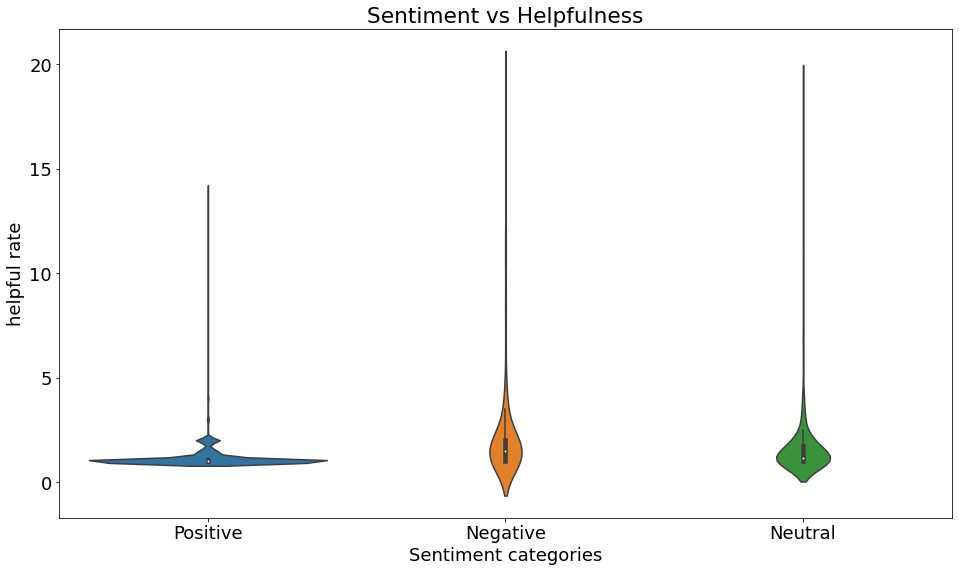

In [26]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

**Day of month vs Reviews count:**
Let's check if there are any relationship between reviews and day of month

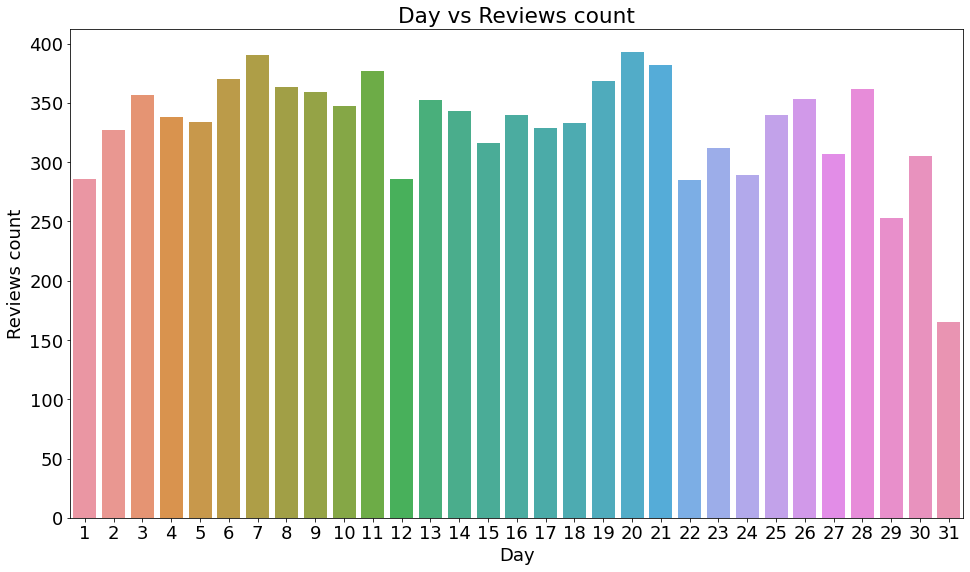

In [27]:
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

**Creating few more features for text analysis:**

Now, let's create polarity, review length and word count

Polarity: We use Textblob for for figuring out the rate of sentiment . It is between [-1,1] where -1 is negative and 1 is positive polarity

Review length: length of the review which includes each letters and spaces

Word length: This measures how many words are there in review

In [28]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [29]:
process_reviews.head()

,reviewerID,asin,overall,reviews,sentiment,year,month,day,helpful_rate,polarity,review_len,word_count
0,A2IBPI20UZIR0U,1384719342,5,not much write but exactly supposed filters po...,Positive,2014,02,28,0.00,0.250000,162,25
1,A14VAT5EAX3D9S,1384719342,5,product exactly quite affordablei not realized...,Positive,2013,03,16,1.08,0.014286,356,55
2,A195EZSQDW3E21,1384719342,5,primary job device block breath would otherwis...,Positive,2013,08,28,1.00,0.167500,315,48
3,A2C00NNG1ZQQG2,1384719342,5,nice windscreen protects mxl mic prevents pops...,Positive,2014,02,14,0.00,0.333333,169,22
4,A94QU4C90B1AX,1384719342,5,pop filter great looks performs like studio fi...,Positive,2014,02,21,0.00,0.800000,136,21


In [32]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

**Wordcloud-Positive reviews**:
Let's look at the word cloud of positive reviews

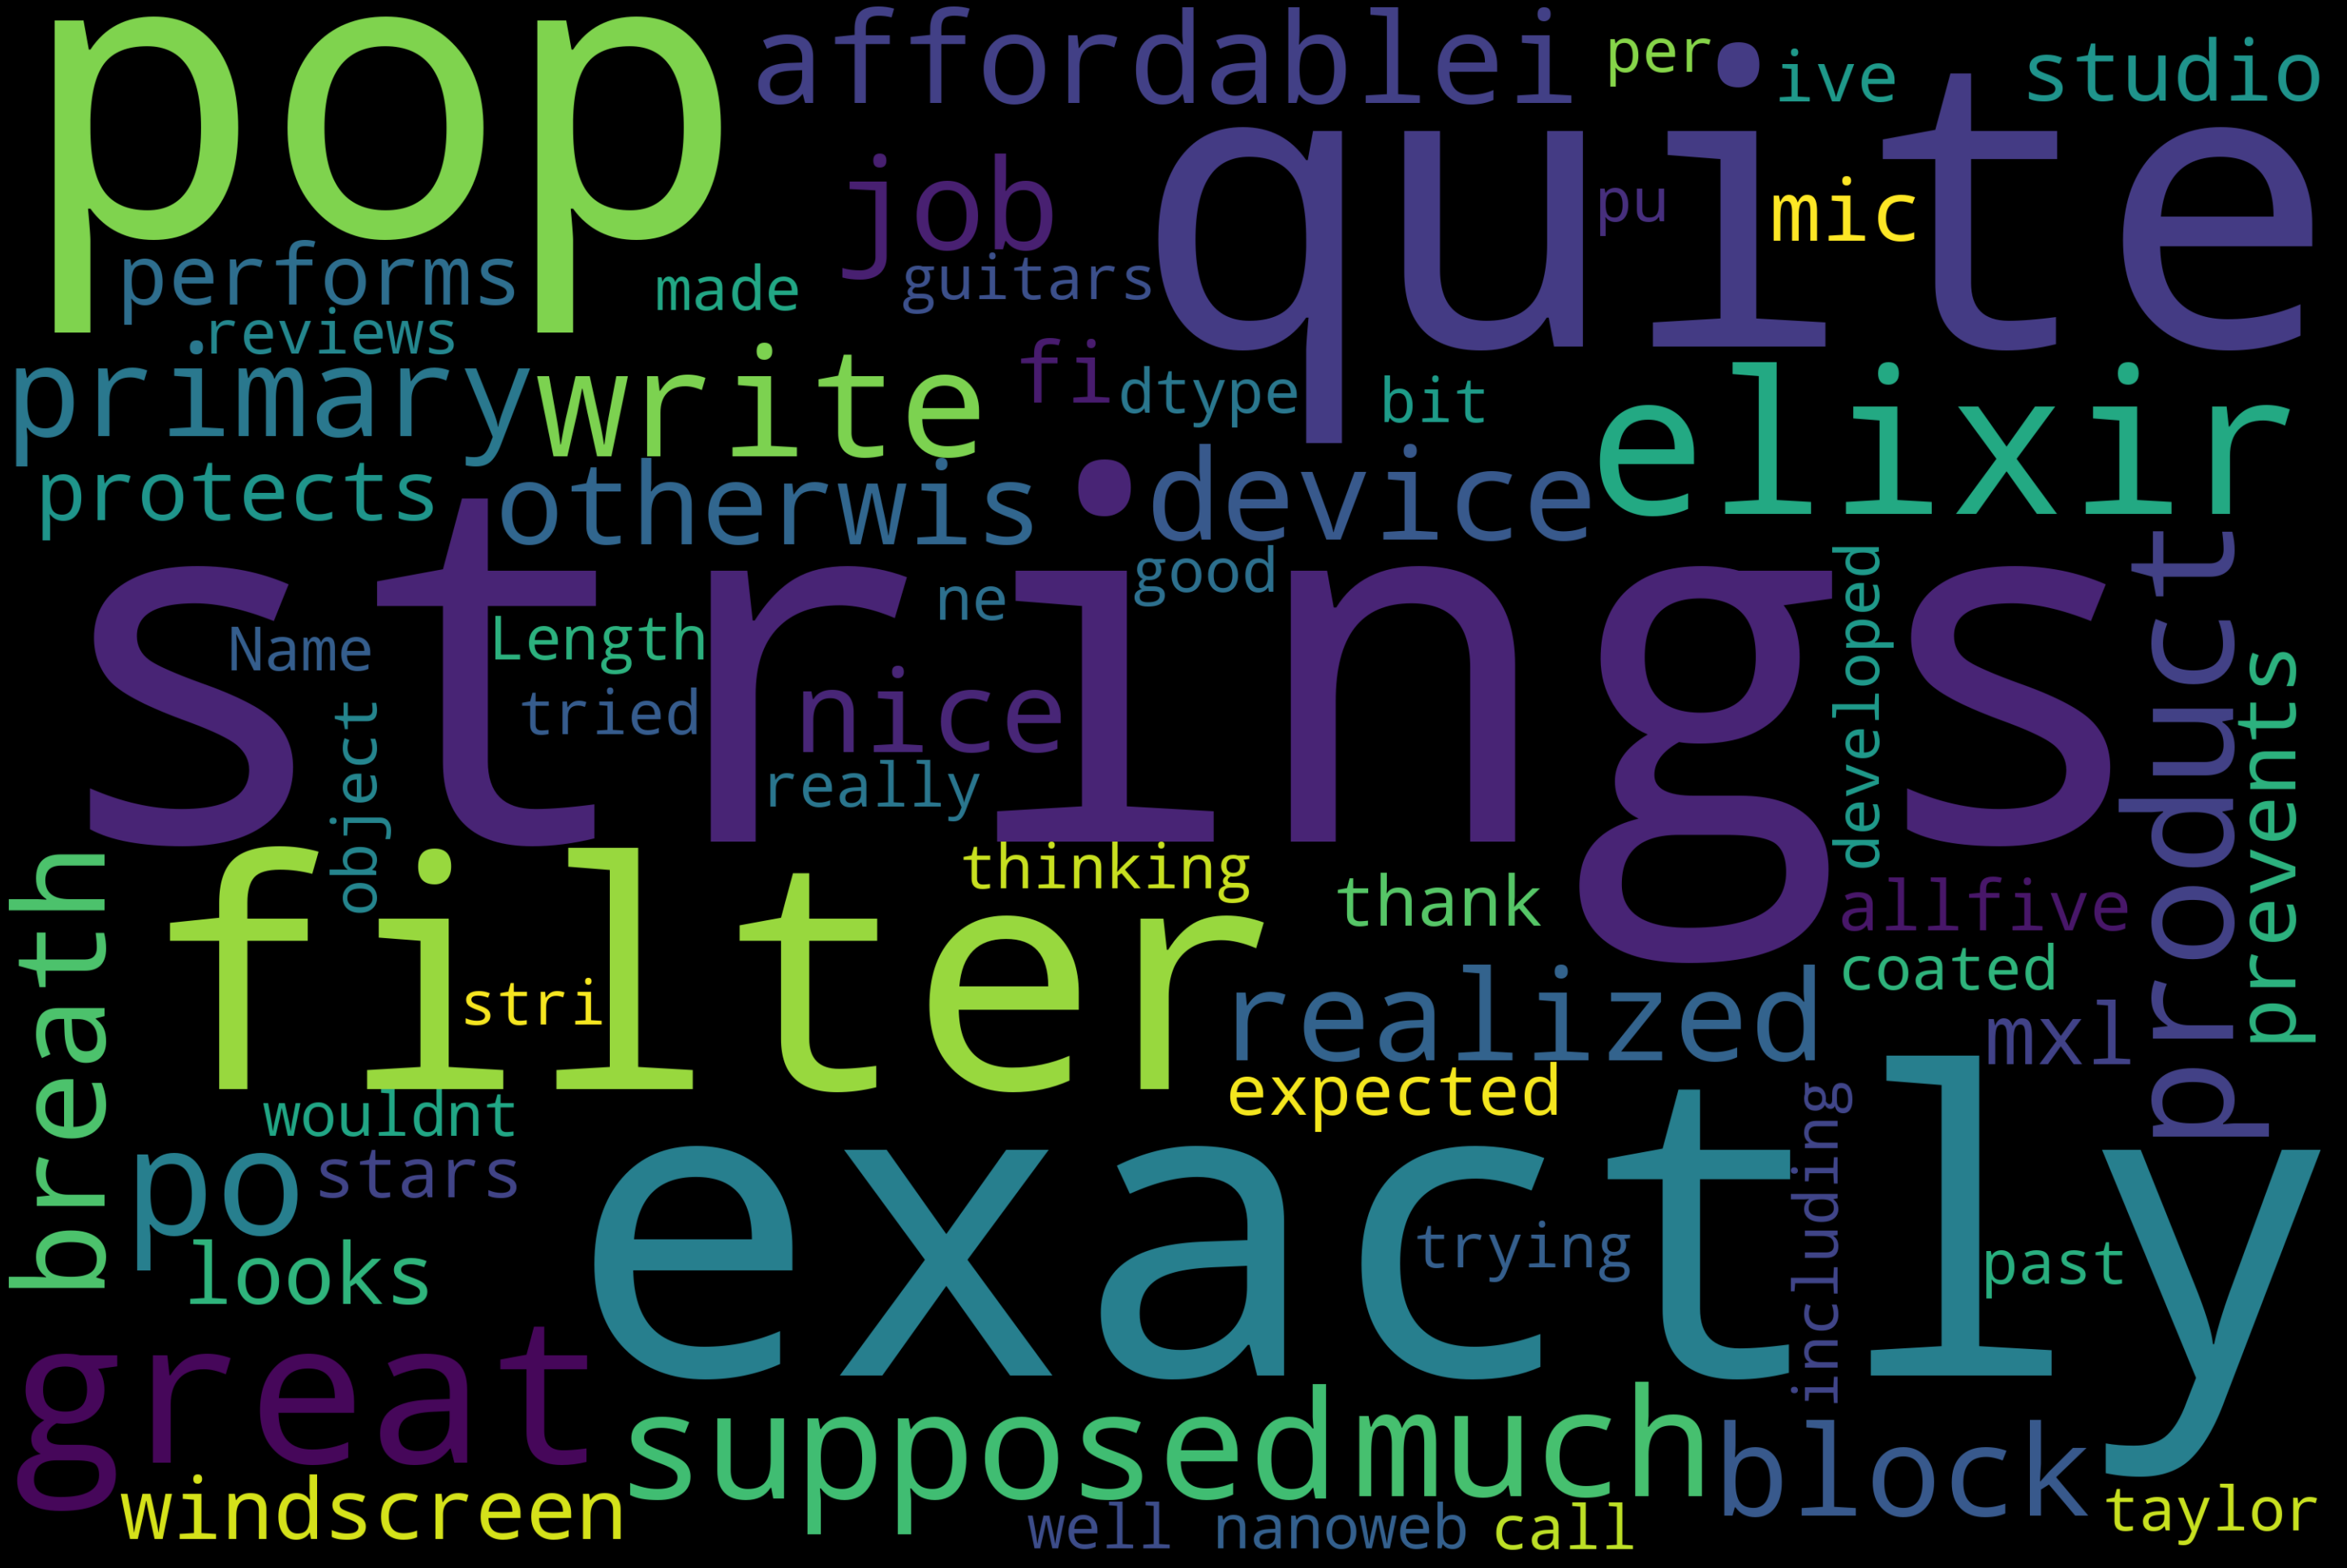

In [33]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Wordcloud-Neutral reviews**:

Let's look at the word cloud of neutral reviews

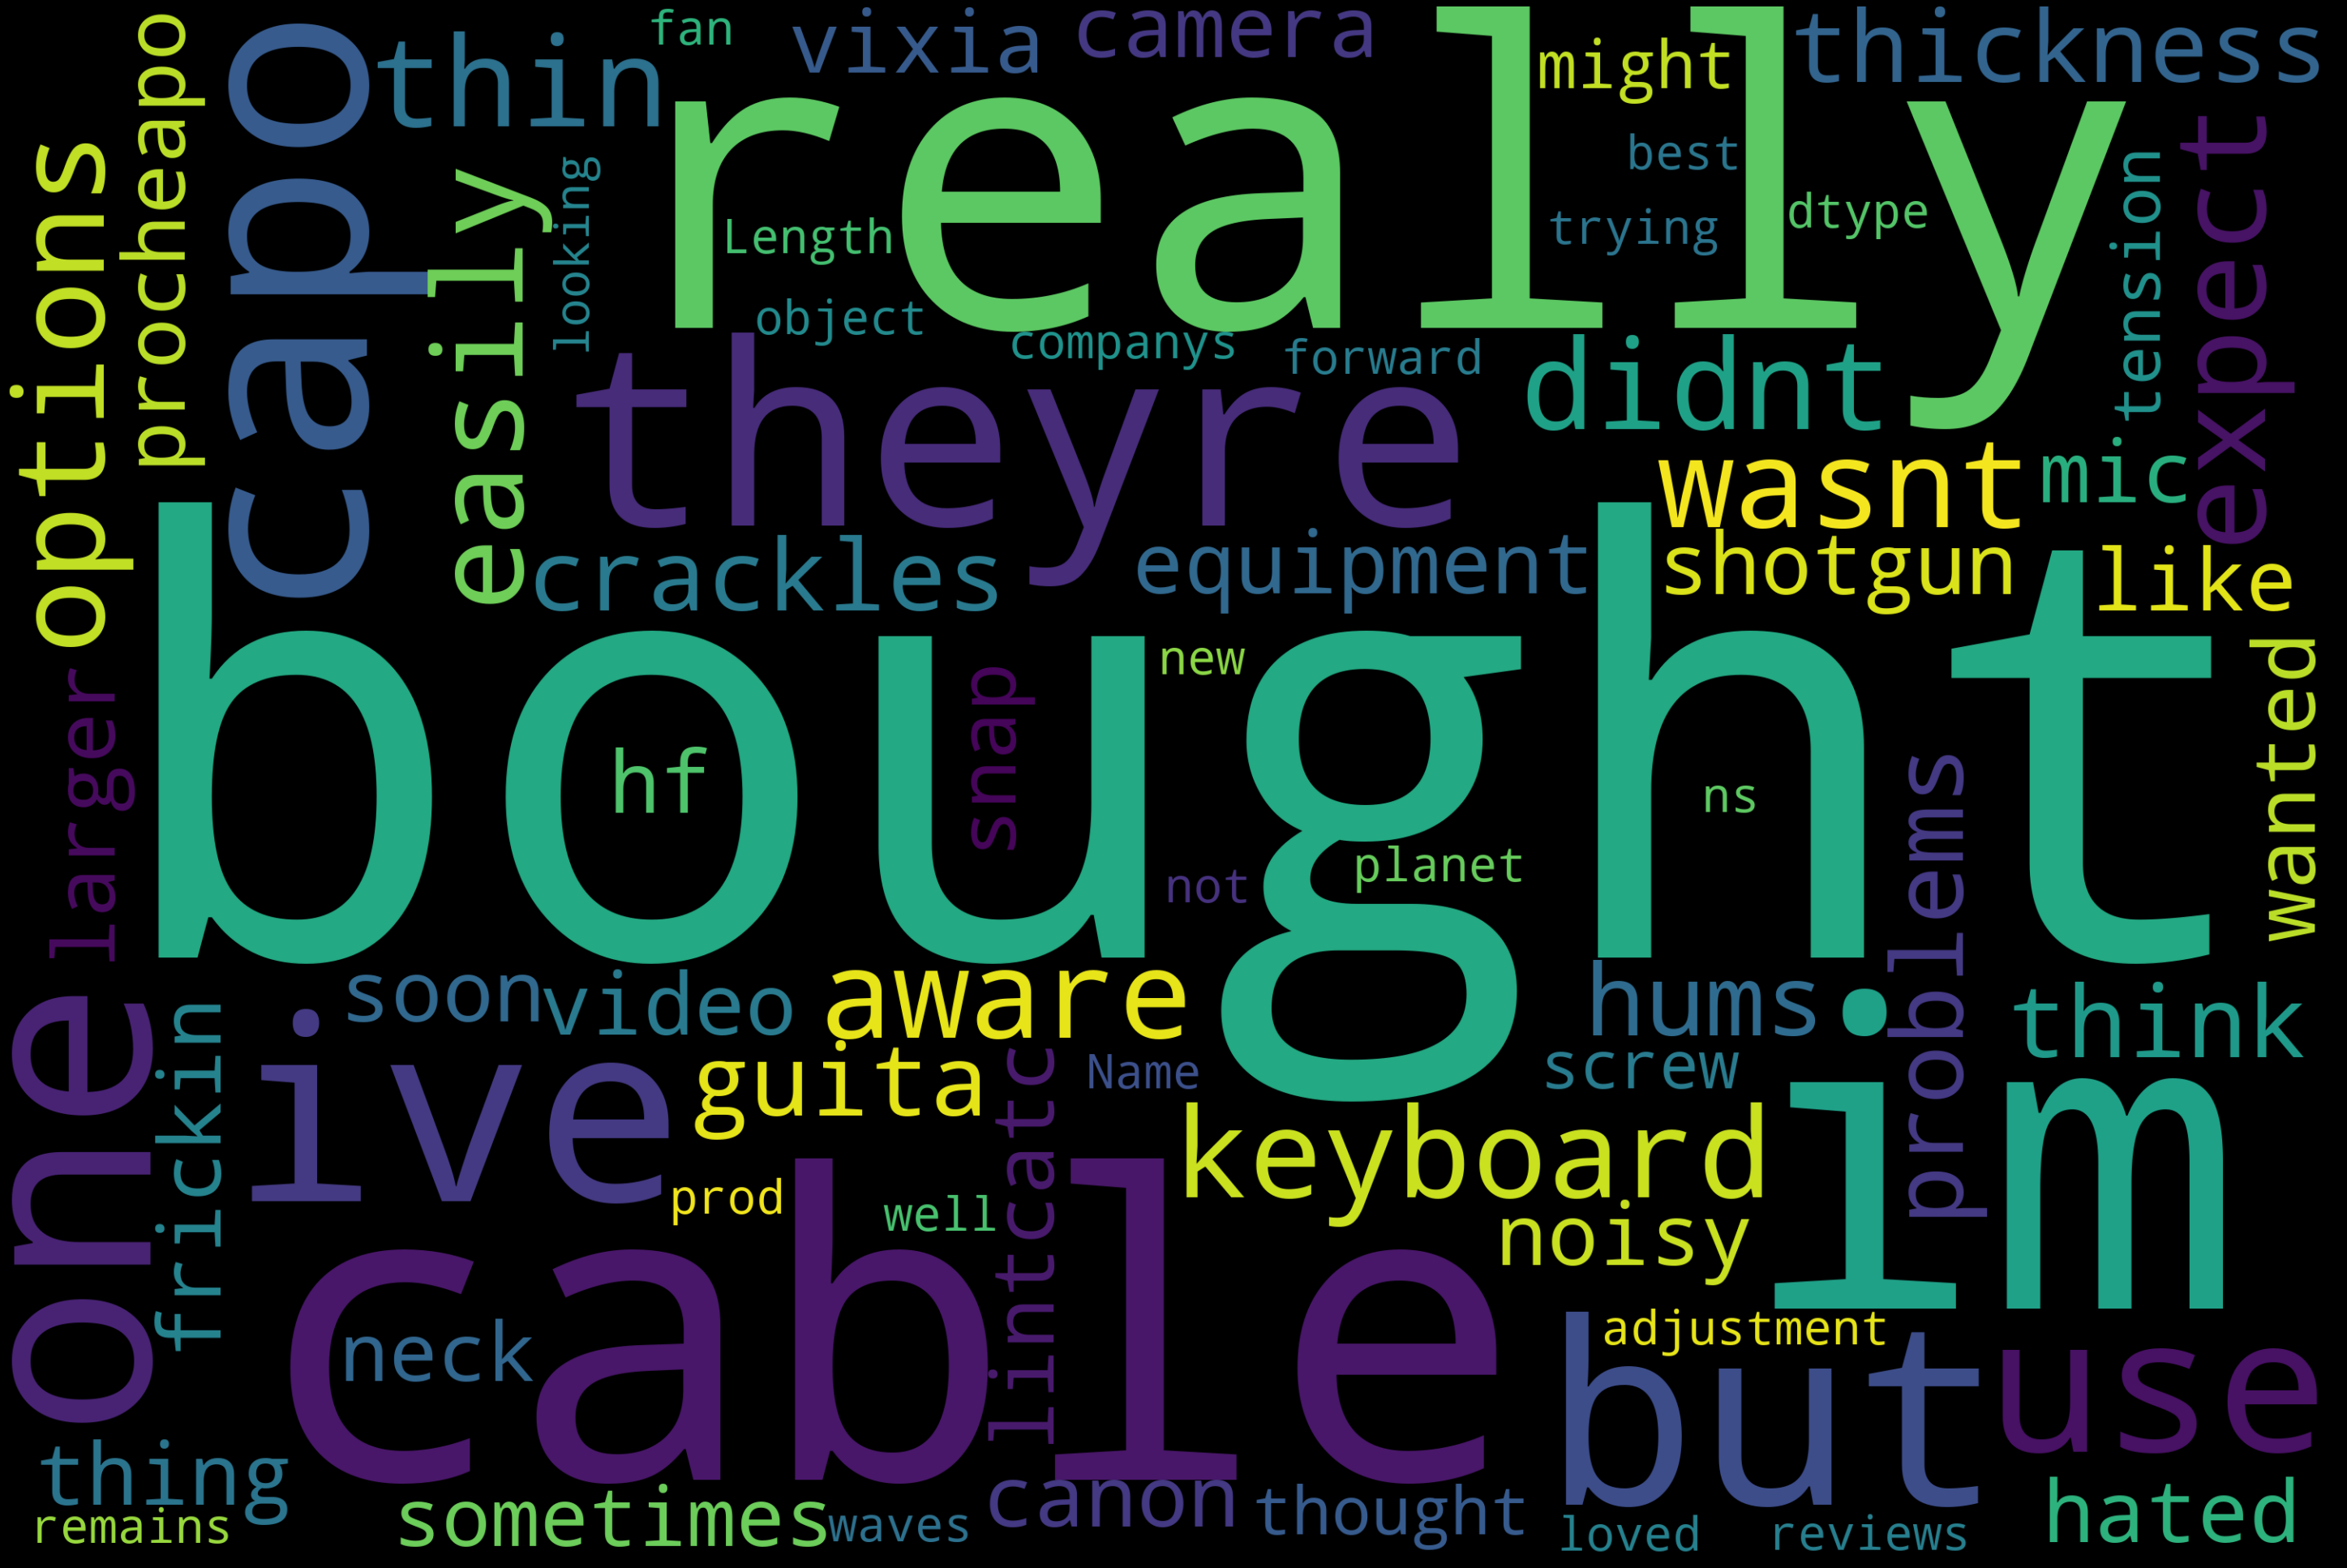

In [34]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Extracting Features from Cleaned reviews:**

Before we build the model for our sentiment analysis, it is required to convert the review texts into vector formation as computer cannot understand words and their sentiment. In this project, we are going to use TF-TDF method to convert the texts

**Encoding target variable-sentiment:**

Let's encode our target variable with Label encoder.

In [35]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique()   

array([2, 1, 0])

In [36]:
process_reviews['sentiment'].value_counts()

2    9022
1     772
0     467
Name: sentiment, dtype: int64

**Stemming the reviews:**

Stemming is a method of deriving root word from the inflected word. Here we extract the reviews and convert the words in reviews to its root word. for example,

Going->go
Finally->fina
If you notice, the root words doesn't need to carry a semantic meaning. There is another technique knows as Lemmatization where it converts the words into root words which has a semantic meaning. Simce it takes time. I'm using stemming

In [37]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

,reviews
0,not much write but exactly supposed filters po...
1,product exactly quite affordablei not realized...
2,primary job device block breath would otherwis...
3,nice windscreen protects mxl mic prevents pops...
4,pop filter great looks performs like studio fi...


In [38]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)    

In [39]:
corpus[3]

'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money'

This is how a line looks like now, as computer cannot understand words and their sentiment we need to convert these words into 1's and 0's. To encode it we use TFIDF

TFIDF(Term Frequency — Inverse Document Frequency)
TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the reviews.

In [40]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [41]:
X.shape

(10261, 5000)

As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.

In [43]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

**Handling Imbalance target feature-SMOTE:**

In our target feature, we noticed that we got a lot of positive sentiments compared to negative and neutral. So it is crucial to balanced the classes in such situatio. Here I use SMOTE(Synthetic Minority Oversampling Technique) to balance out the imbalanced dataset problem.It aims to balance class distribution by randomly increasing minority class examples by replicating them.

SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [44]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 9022, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


Great, as you can see the resampled data has equally distributed classes

Train-test split(75:25)
Using train test split function we are splitting the dataset into 75:25 ratio for train and test set respectively.

In [46]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

**Model Building: Sentiment Analysis**

As we have successfully processed the text data, not it is just a normal machine learning problem. Where from the sparse matrix we predict the classes in target feature.

**Model selection:**

First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process

In [47]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8809084541929313
Decision Tree Test Accuracy: 0.8167833030591192
KNN Test Accuracy: 0.8734040554160474
SVC Test Accuracy: 0.8795439317757772
Naive Bayes Test Accuracy: 0.8031363706247119


From the results, we can see logistic regression outdone the rest of the algorithms and all the accuracies from the results are more than 80%. That's great. So let's go with logistic regression with hyperparameter tuning.

**Logistic Regression with Hyperparameter tuning**

We use regularization parameter and penality for parameter tuning. let's see which one to plug.

In [48]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
The mean accuracy of the model is: 0.9389685237180434


From the selected params, we get accuracy. Let's plug and chug

In [49]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


We have got 94% accuracy. That ain't bad. But for classification problems we need to get confusion matrix and check f1 score rather than accuracy

**Classification metrics**:

Here we plot the confusion matrix with ROC and check our f1 score

In [51]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


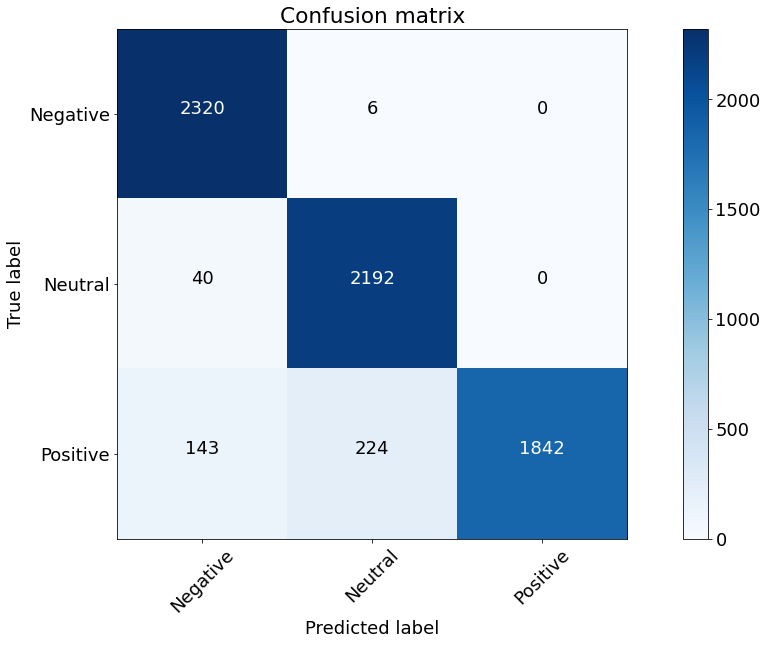

In [52]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

Check out the diagonal elements(2320+2192+1842), they are correctly predicted records and rest are incorrectly classified by the algorithm

In [53]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2326
           1       0.91      0.98      0.94      2232
           2       1.00      0.83      0.91      2209

    accuracy                           0.94      6767
   macro avg       0.94      0.94      0.94      6767
weighted avg       0.94      0.94      0.94      6767



Since predicting both positive,negative and neutral reviews are important we are considering.We got a pretty good f1 score. As we see it got a good score across all classes classified